In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy import stats
from sklearn.model_selection import GridSearchCV
import optuna
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC

In [ ]:
mcdf=pd.read_csv('match_without_json.csv')

In [ ]:
mcdf.columns # 상대 방이 몰수 패를 하면 무조건 화면에 내가 넣은 골이 3으로 뜨기 때문에,
# shoot.goalTotalDisplay 삭제
mcdf=mcdf.drop(['shoot.goalTotalDisplay','matchDetail.averageRating'],axis=1)

In [ ]:
mcdf['matchDetail.controller_gamepad']

0        False
1        False
2        False
3        False
4        False
         ...  
27194    False
27195    False
27196    False
27197    False
27198    False
Name: matchDetail.controller_gamepad, Length: 27199, dtype: bool

### Logistic Regression

In [ ]:
# 데이터 로드 및 전처리
mcdf = pd.read_csv('match_without_json.csv')
mcdf = mcdf.drop(['shoot.goalTotalDisplay', 'matchDetail.averageRating'], axis=1)

# 카테고리형 및 수치형 피처 구분
categorical_features = ['matchDetail.controller_gamepad', 'matchDetail.controller_keyboard']
numeric_features = [col for col in mcdf.columns[3:] if col not in categorical_features]

# 이상치 탐지 및 대체
z_scores = np.abs(stats.zscore(mcdf[numeric_features]))
threshold = 3
for col in numeric_features:
    median = mcdf[col].median()
    mcdf.loc[np.abs(stats.zscore(mcdf[col])) > threshold, col] = median

# 데이터 분리
X = mcdf.drop('matchDetail.matchResult', axis=1)
y = mcdf['matchDetail.matchResult']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Optuna를 활용한 하이퍼파라미터 튜닝
def objective(trial):
    param = {
        'classifier__C': trial.suggest_loguniform('classifier__C', 1e-4, 1e2),
        'classifier__solver': trial.suggest_categorical('classifier__solver', ['liblinear', 'saga']),
        'classifier__penalty': trial.suggest_categorical('classifier__penalty', ['l1', 'l2'])
    }

    # 파이프라인 생성
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(), categorical_features)
        ])

    pipeline_lg = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ])

    pipeline_lg.set_params(**param)
    return cross_val_score(pipeline_lg, X_train, y_train, cv=5, scoring='accuracy').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# 최적 파라미터 설정 및 학습
best_params = study.best_trial.params

# 파이프라인 생성 및 학습
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

pipeline_lg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

pipeline_lg.set_params(**best_params)
pipeline_lg.fit(X_train, y_train)

# 예측 및 평가
y_pred = pipeline_lg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

[I 2024-07-13 17:20:57,758] A new study created in memory with name: no-name-b16c59f7-b35e-4075-bc6f-f037978f5919
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\1278698827.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'classifier__C': trial.suggest_loguniform('classifier__C', 1e-4, 1e2),
[I 2024-07-13 17:20:59,044] Trial 0 finished with value: 0.7272969905062103 and parameters: {'classifier__C': 0.006232620931287283, 'classifier__solver': 'saga', 'classifier__penalty': 'l2'}. Best is trial 0 with value: 0.7272969905062103.
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\1278698827.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'classifier__C': trial.su

In [ ]:
print(f"Accuracy: {accuracy}")
print('-'*100)
print("Confusion Matrix:\n", conf_matrix)
print('-'*100)
print("Classification Report:\n", class_report)
print('-'*100)
print("bestparams:", study.best_params)

Accuracy: 0.7313725490196078
----------------------------------------------------------------------------------------------------
Confusion Matrix:
 [[2859    1  531]
 [ 554    8  448]
 [ 653    5 3101]]
----------------------------------------------------------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

          -1       0.70      0.84      0.77      3391
           0       0.57      0.01      0.02      1010
           1       0.76      0.82      0.79      3759

    accuracy                           0.73      8160
   macro avg       0.68      0.56      0.52      8160
weighted avg       0.71      0.73      0.69      8160

----------------------------------------------------------------------------------------------------
bestparams: {'classifier__C': 0.023049515538184247, 'classifier__solver': 'liblinear', 'classifier__penalty': 'l2'}



Top 10 Features by Importance:

shoot.goalTotal                          1.213966
shoot.goalInPenalty                      0.488905
matchDetail.possession                   0.433146
shoot.shootTotal                         0.272574
pass.passTry                             0.222915
shoot.goalOutPenalty                     0.207316
matchDetail.controller_keyboard_False    0.197463
matchDetail.controller_gamepad_True      0.197463
matchDetail.controller_gamepad_False     0.196675
matchDetail.controller_keyboard_True     0.196675
dtype: float64


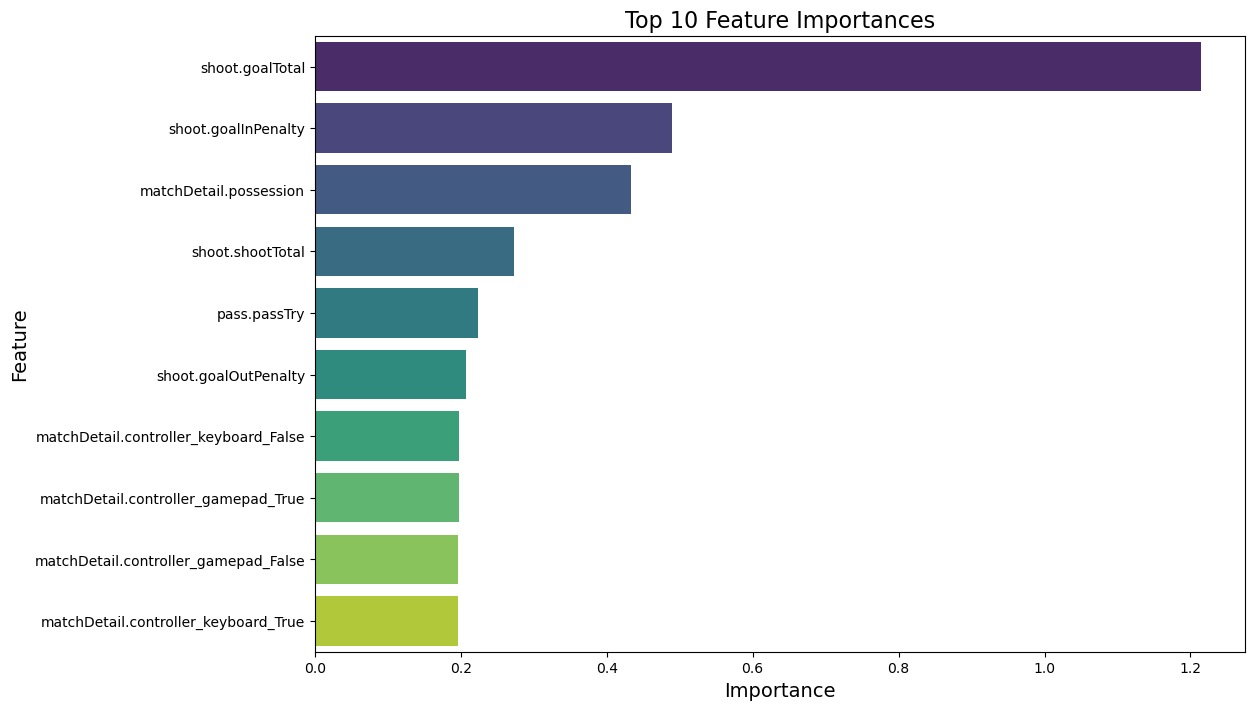

In [ ]:
# 피처 중요도 계산
classifier = pipeline_lg.named_steps['classifier']
coefficients = classifier.coef_[0]

# OneHotEncoder의 get_feature_names_out()을 통해 피처 이름을 가져오기
encoder = pipeline_lg.named_steps['preprocessor'].named_transformers_['cat']
encoded_categorical_features = encoder.get_feature_names_out(categorical_features)

# 모든 피처 이름 결합
all_features = np.concatenate([numeric_features, encoded_categorical_features])

# 피처 중요도 상위 10개 출력 및 시각화
feature_importance = pd.Series(coefficients, index=all_features).abs().sort_values(ascending=False)
top_10_features = feature_importance.head(10)

print("\nTop 10 Features by Importance:\n")
print(top_10_features)

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='viridis')
plt.title('Top 10 Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()

## 2. RandomForest

In [ ]:

# 이상치 처리
z_scores = np.abs(stats.zscore(mcdf[numeric_features]))
threshold = 3
for col in numeric_features:
    median = mcdf[col].median()
    mcdf.loc[np.abs(stats.zscore(mcdf[col])) > threshold, col] = median

# 데이터 분할
X = mcdf.drop('matchDetail.matchResult', axis=1)
y = mcdf['matchDetail.matchResult']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 전처리 파이프라인 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Optuna를 사용한 하이퍼파라미터 튜닝
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    }

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(**param, random_state=42))
    ])

    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# 최적의 하이퍼파라미터를 사용하여 최종 모델 학습
best_params = study.best_trial.params

pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(**best_params, random_state=42))
])

pipeline_rf.fit(X_train, y_train)

# 모델 예측 및 성능 평가
y_pred = pipeline_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

[I 2024-07-13 17:22:13,565] A new study created in memory with name: no-name-c8db3c15-b850-4455-b9da-84bb1f182e41
[I 2024-07-13 17:22:33,412] Trial 0 finished with value: 0.7297125844033436 and parameters: {'n_estimators': 202, 'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7297125844033436.
[I 2024-07-13 17:23:41,189] Trial 1 finished with value: 0.7287671648643697 and parameters: {'n_estimators': 702, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.7297125844033436.
C:\Users\rlatk\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\rlatk\A

In [ ]:
print(accuracy)
print('-'*100)
print(conf_matrix)
print('-'*100)
print(class_report)

0.7357843137254902
----------------------------------------------------------------------------------------------------
[[2770    3  618]
 [ 484    6  520]
 [ 526    5 3228]]
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

          -1       0.73      0.82      0.77      3391
           0       0.43      0.01      0.01      1010
           1       0.74      0.86      0.79      3759

    accuracy                           0.74      8160
   macro avg       0.63      0.56      0.53      8160
weighted avg       0.70      0.74      0.69      8160




Top 10 Features by Importance:

shoot.goalTotal              0.253116
shoot.goalInPenalty          0.127670
shoot.effectiveShootTotal    0.085905
shoot.shootTotal             0.058197
matchDetail.possession       0.049063
shoot.shootInPenalty         0.040631
defence.blockTry             0.036846
pass.passTry                 0.034051
matchDetail.dribble          0.032649
pass.passSuccess             0.029926
dtype: float64


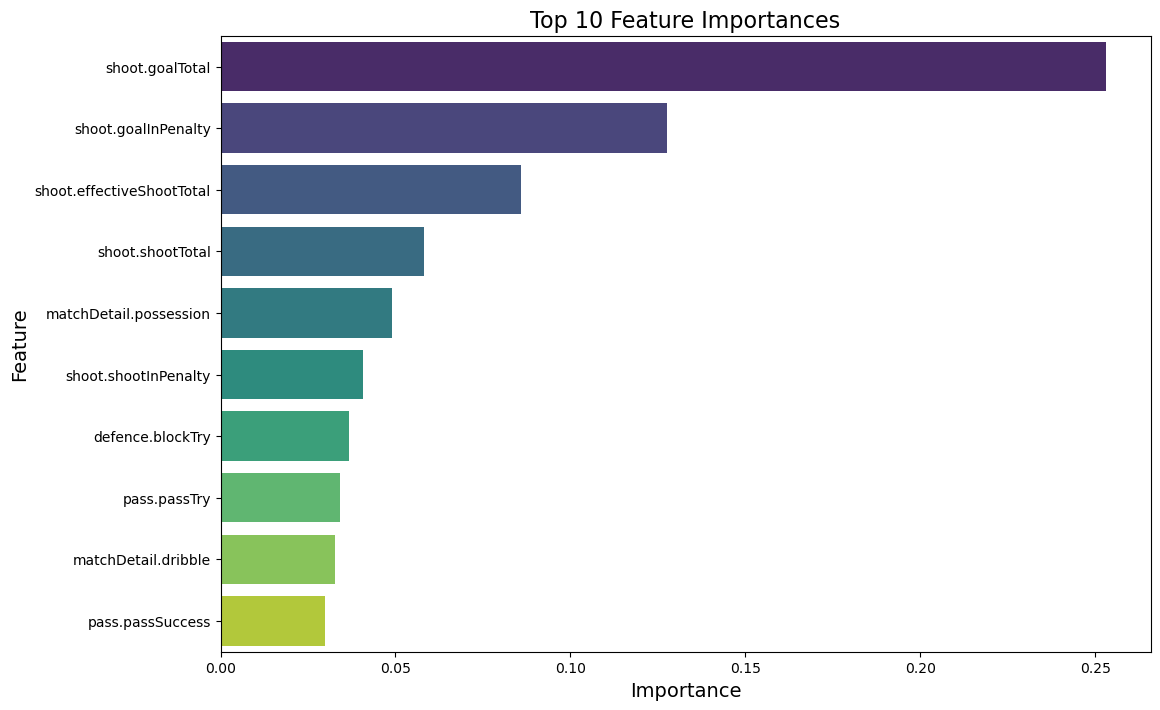

In [ ]:
# 피처 중요도 계산
classifier = pipeline_rf.named_steps['classifier']
importances = classifier.feature_importances_

# OneHotEncoder의 get_feature_names_out()을 통해 피처 이름을 가져오기
encoder = pipeline_rf.named_steps['preprocessor'].named_transformers_['cat']
encoded_categorical_features = encoder.get_feature_names_out(categorical_features)

# 모든 피처 이름 결합
all_features = np.concatenate([numeric_features, encoded_categorical_features])

# 피처 중요도 상위 10개 출력 및 시각화
feature_importance = pd.Series(importances, index=all_features).sort_values(ascending=False)
top_10_features = feature_importance.head(10)

print("\nTop 10 Features by Importance:\n")
print(top_10_features)

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='viridis')
plt.title('Top 10 Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()

## 2. Xgboost

In [ ]:
mcdf = pd.read_csv('match_without_json.csv')
mcdf = mcdf.drop(['shoot.goalTotalDisplay', 'matchDetail.averageRating'], axis=1)
mcdf['matchDetail.matchResult'] = mcdf['matchDetail.matchResult'].replace({-1: 0, 0: 1, 1: 2})

categorical_features = ['matchDetail.controller_gamepad', 'matchDetail.controller_keyboard']
numeric_features = [col for col in mcdf.columns[3:] if col not in categorical_features]

# 이상치 처리
z_scores = np.abs(stats.zscore(mcdf[numeric_features]))
threshold = 3

for col in numeric_features:
    median = mcdf[col].median()
    mcdf.loc[np.abs(stats.zscore(mcdf[col])) > threshold, col] = median

X = mcdf.drop('matchDetail.matchResult', axis=1)
y = mcdf['matchDetail.matchResult']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 전처리 파이프라인 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Optuna를 사용한 하이퍼파라미터 튜닝
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'multi:softprob',
        'num_class': 3,
        'eval_metric': 'mlogloss',
        'eta': trial.suggest_loguniform('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 0.1, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
    }

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(**param, use_label_encoder=False))
    ])

    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# 최적의 하이퍼파라미터를 사용하여 최종 모델 학습
best_params = study.best_trial.params
best_params['verbosity'] = 0
best_params['objective'] = 'multi:softprob'
best_params['num_class'] = 3
best_params['eval_metric'] = 'mlogloss'

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(**best_params, use_label_encoder=False))
])

pipeline_xgb.fit(X_train, y_train)

# 평가
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

[I 2024-07-13 17:33:13,369] A new study created in memory with name: no-name-3ea14b7d-8210-4790-af9e-d796efcac2ed
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\2755335131.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\2755335131.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.1, 1.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\2755335131.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

In [ ]:
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.7379901960784314
Confusion Matrix:
[[2823    1  567]
 [ 527    1  482]
 [ 556    5 3198]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.83      0.77      3391
           1       0.14      0.00      0.00      1010
           2       0.75      0.85      0.80      3759

    accuracy                           0.74      8160
   macro avg       0.54      0.56      0.52      8160
weighted avg       0.66      0.74      0.69      8160



In [ ]:
mcdf['matchDetail.matchResult'].value_counts()

matchDetail.matchResult
2    12490
0    11277
1     3432
Name: count, dtype: int64

['matchDetail.possession', 'shoot.goalTotal', 'pass.passTry', 'defence.blockTry', 'matchDetail.dribble', 'shoot.shootTotal', 'pass.shortPassTry', 'pass.passSuccess', 'pass.shortPassSuccess', 'defence.tackleTry']


C:\Users\rlatk\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


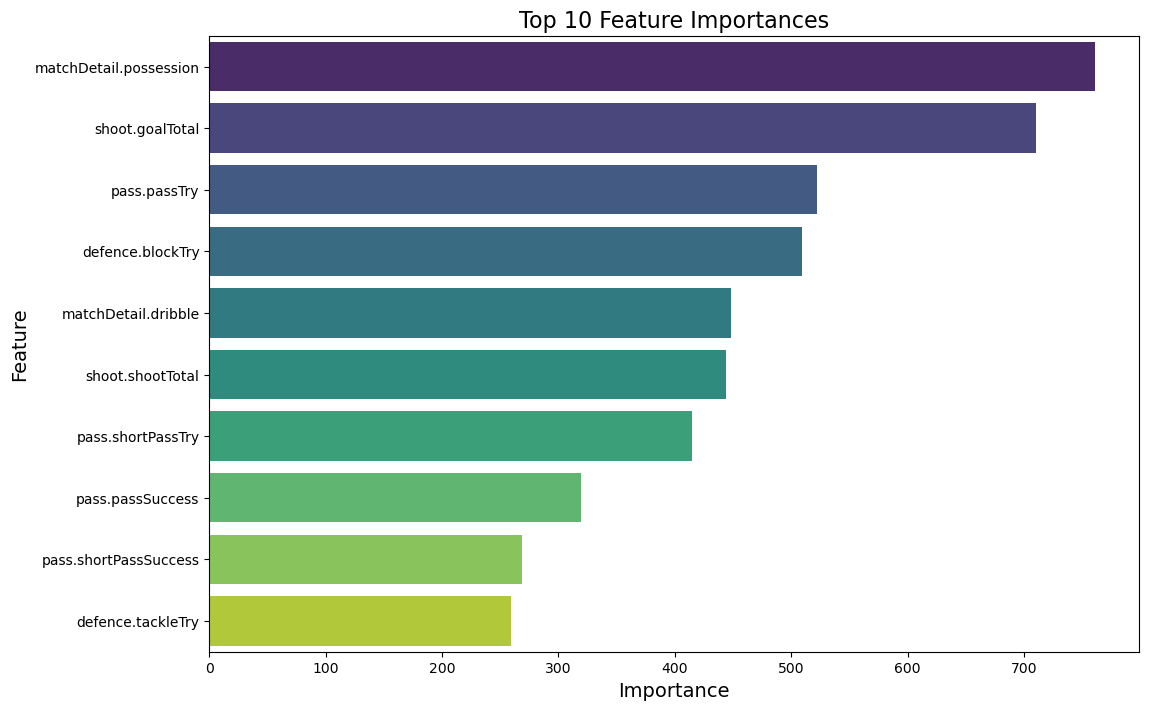

In [ ]:
classifier = pipeline_xgb.named_steps['classifier']
feature_importances = classifier.get_booster().get_score(importance_type='weight')
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
top_10_features = sorted_features[:10]

# 피처 이름 가져오기
encoder = preprocessor.named_transformers_['cat']
encoded_categorical_features = encoder.get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_features, encoded_categorical_features])

# 피처 이름 매핑
features = [all_features[int(f[0][1:])] for f in top_10_features]
importances = [f[1] for f in top_10_features]

print(features )
plt.figure(figsize=(12, 8))
sns.barplot(x=importances, y=features, palette='viridis')
plt.title('Top 10 Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()

## 4.lightgbm

In [ ]:
mcdf = pd.read_csv('match_without_json.csv')
mcdf = mcdf.drop(['shoot.goalTotalDisplay', 'matchDetail.averageRating'], axis=1)
mcdf['matchDetail.matchResult'] = mcdf['matchDetail.matchResult'].replace({-1: 0, 0: 1, 1: 2})

categorical_features = ['matchDetail.controller_gamepad', 'matchDetail.controller_keyboard']
numeric_features = [col for col in mcdf.columns[3:] if col not in categorical_features]

# 이상치 처리
z_scores = np.abs(stats.zscore(mcdf[numeric_features]))
threshold = 3
outliers = np.where(z_scores > threshold)

for col in numeric_features:
    median = mcdf[col].median()
    mcdf.loc[np.abs(stats.zscore(mcdf[col])) > threshold, col] = median

X = mcdf.drop('matchDetail.matchResult', axis=1)
y = mcdf['matchDetail.matchResult']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Optuna를 사용한 하이퍼파라미터 튜닝
def objective(trial):
    param = {
        'objective': 'multiclass',
        'num_class': 3,
        'metric': 'multi_logloss',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 20),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1.0)
    }

    pipeline_lgb = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', lgb.LGBMClassifier(**param))
    ])

    pipeline_lgb.fit(X_train, y_train)
    preds = pipeline_lgb.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

best_params = study.best_trial.params
best_params['objective'] = 'multiclass'
best_params['num_class'] = 3
best_params['metric'] = 'multi_logloss'

pipeline_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(**best_params))
])

pipeline_lgb.fit(X_train, y_train)

# 평가
preds = pipeline_lgb.predict(X_test)
accuracy = accuracy_score(y_test, preds)
conf_matrix = confusion_matrix(y_test, preds)
class_report = classification_report(y_test, preds)

[I 2024-07-13 17:34:16,761] A new study created in memory with name: no-name-59a0b71a-8e3a-438c-a701-29d5b04c0ccf
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optun

[LightGBM] [Warning] feature_fraction is set=0.7842805150531682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7842805150531682
[LightGBM] [Warning] lambda_l1 is set=0.03631278142129491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03631278142129491
[LightGBM] [Warning] lambda_l2 is set=2.517549919410487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.517549919410487
[LightGBM] [Warning] bagging_fraction is set=0.7560188342440578, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7560188342440578
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.7842805150531682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7842805150531682
[LightGBM] [Warning] lambda_l1 is set=0.03631278142129491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03631278142129491
[LightGBM] [Warning] lambda_l2 is s

[I 2024-07-13 17:34:17,275] Trial 0 finished with value: 0.725735294117647 and parameters: {'learning_rate': 0.22439638001341092, 'max_depth': 6, 'num_leaves': 101, 'feature_fraction': 0.7842805150531682, 'bagging_fraction': 0.7560188342440578, 'bagging_freq': 2, 'lambda_l1': 0.03631278142129491, 'lambda_l2': 2.517549919410487, 'min_child_samples': 20, 'min_child_weight': 0.001263222933413091}. Best is trial 0 with value: 0.725735294117647.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] feature_fraction is set=0.9264477205588705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9264477205588705
[LightGBM] [Warning] lambda_l1 is set=0.33603441465801087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33603441465801087
[LightGBM] [Warning] lambda_l2 is set=0.36546294727424883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.36546294727424883
[LightGBM] [Warning] bagging_fraction is set=0.9732984057235983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9732984057235983
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9264477205588705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9264477205588705
[LightGBM] [Warning] lambda_l1 is set=0.33603441465801087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33603441465801087
[LightGBM] [Warning] lambda_l2 

[I 2024-07-13 17:34:17,926] Trial 1 finished with value: 0.7323529411764705 and parameters: {'learning_rate': 0.09705231433564403, 'max_depth': 8, 'num_leaves': 94, 'feature_fraction': 0.9264477205588705, 'bagging_fraction': 0.9732984057235983, 'bagging_freq': 2, 'lambda_l1': 0.33603441465801087, 'lambda_l2': 0.36546294727424883, 'min_child_samples': 12, 'min_child_weight': 0.5845409589176819}. Best is trial 1 with value: 0.7323529411764705.
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

[LightGBM] [Warning] feature_fraction is set=0.9531542221516421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9531542221516421
[LightGBM] [Warning] lambda_l1 is set=2.9133244613970857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9133244613970857
[LightGBM] [Warning] lambda_l2 is set=0.21897448062108357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21897448062108357
[LightGBM] [Warning] bagging_fraction is set=0.7938433548313053, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7938433548313053
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9531542221516421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9531542221516421
[LightGBM] [Warning] lambda_l1 is set=2.9133244613970857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9133244613970857
[LightGBM] [Warning] lambda_l2 is s

[I 2024-07-13 17:34:18,301] Trial 2 finished with value: 0.7377450980392157 and parameters: {'learning_rate': 0.03512247740563672, 'max_depth': 5, 'num_leaves': 30, 'feature_fraction': 0.9531542221516421, 'bagging_fraction': 0.7938433548313053, 'bagging_freq': 2, 'lambda_l1': 2.9133244613970857, 'lambda_l2': 0.21897448062108357, 'min_child_samples': 14, 'min_child_weight': 0.015437692456220915}. Best is trial 2 with value: 0.7377450980392157.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-13 17:34:18,774] Trial 3 finished with value: 0.7235294117647059 and parameters: {'learning_rate': 0.21164378932391573, 'max_depth': 6, 'num_leaves': 136, 'feature_fraction': 0.5110272390035084, 'bagging_fraction': 0.6991964487350752, 'bagging_freq': 3, 'lambda_l1': 0.19474395881564882, 'lambda_l2': 0.029261352424910236, 'min_child_samples': 17, 'min_child_weight': 0.004170118372242164}. Best is trial 2 with value: 0.7377450980392157.
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/o

[LightGBM] [Warning] feature_fraction is set=0.6047151561268861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6047151561268861
[LightGBM] [Warning] lambda_l1 is set=0.4402861770882382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4402861770882382
[LightGBM] [Warning] lambda_l2 is set=3.0643661294394797, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0643661294394797
[LightGBM] [Warning] bagging_fraction is set=0.719928848980556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.719928848980556
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6047151561268861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6047151561268861
[LightGBM] [Warning] lambda_l1 is set=0.4402861770882382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4402861770882382
[LightGBM] [Warning] lambda_l2 is set=3

[I 2024-07-13 17:34:19,082] Trial 4 finished with value: 0.7375 and parameters: {'learning_rate': 0.07202017792038154, 'max_depth': 4, 'num_leaves': 82, 'feature_fraction': 0.6047151561268861, 'bagging_fraction': 0.719928848980556, 'bagging_freq': 5, 'lambda_l1': 0.4402861770882382, 'lambda_l2': 3.0643661294394797, 'min_child_samples': 10, 'min_child_weight': 0.019574192770130807}. Best is trial 2 with value: 0.7377450980392157.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-13 17:34:19,497] Trial 5 finished with value: 0.7267156862745098 and parameters: {'learning_rate': 0.18863970865291932, 'max_depth': 6, 'num_leaves': 125, 'feature_fraction': 0.8861376162543615, 'bagging_fraction': 0.7714758518033112, 'bagging_freq': 6, 'lambda_l1': 0.002788044944232743, 'lambda_l2': 0.858230366440215, 'min_child_samples': 9, 'min_child_weight': 0.06715518280721391}. Best is trial 2 with value: 0.7377450980392157.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-13 17:34:20,341] Trial 6 finished with value: 0.7224264705882353 and parameters: {'learning_rate': 0.13001441238393185, 'max_depth': 9, 'num_leaves': 138, 'feature_fraction': 0.7738264691418104, 'bagging_fraction': 0.6605851995723069, 'bagging_freq': 6, 'lambda_l1': 1.1771636893221702, 'lambda_l2': 0.0030982156435311755, 'min_child_samples': 6, 'min_child_weight': 0.3847879887517448}. Best is trial 2 with value: 0.7377450980392157.


[LightGBM] [Warning] feature_fraction is set=0.7738264691418104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7738264691418104
[LightGBM] [Warning] lambda_l1 is set=1.1771636893221702, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1771636893221702
[LightGBM] [Warning] lambda_l2 is set=0.0030982156435311755, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0030982156435311755
[LightGBM] [Warning] bagging_fraction is set=0.6605851995723069, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6605851995723069
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.9132785426907607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9132785426907607
[LightGBM] [Warning] lambda_l1 is set=0.03503197762765146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03503197762765146
[LightGBM] [Warning] lambda_l

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-13 17:34:20,811] Trial 7 finished with value: 0.7333333333333333 and parameters: {'learning_rate': 0.08071117922024691, 'max_depth': 8, 'num_leaves': 39, 'feature_fraction': 0.9132785426907607, 'bagging_fraction': 0.9228751407416125, 'bagging_freq': 7, 'lambda_l1': 0.03503197762765146, 'lambda_l2': 0.4008460707595366, 'min_child_samples': 8, 'min_child_weight': 0.0033543535279886875}. Best is trial 2 with value: 0.7377450980392157.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.9132785426907607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9132785426907607
[LightGBM] [Warning] lambda_l1 is set=0.03503197762765146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03503197762765146
[LightGBM] [Warning] lambda_l2 is set=0.4008460707595366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4008460707595366
[LightGBM] [Warning] bagging_fraction is set=0.9228751407416125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9228751407416125
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] f

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-13 17:34:21,203] Trial 8 finished with value: 0.7303921568627451 and parameters: {'learning_rate': 0.17844084538926738, 'max_depth': 6, 'num_leaves': 26, 'feature_fraction': 0.6248338178852102, 'bagging_fraction': 0.9783358776847662, 'bagging_freq': 6, 'lambda_l1': 0.014570969645960155, 'lambda_l2': 1.9479966709367678, 'min_child_samples': 8, 'min_child_weight': 0.12843351375879708}. Best is trial 2 with value: 0.7377450980392157.


[LightGBM] [Warning] feature_fraction is set=0.6248338178852102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6248338178852102
[LightGBM] [Warning] lambda_l1 is set=0.014570969645960155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014570969645960155
[LightGBM] [Warning] lambda_l2 is set=1.9479966709367678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9479966709367678
[LightGBM] [Warning] bagging_fraction is set=0.9783358776847662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9783358776847662
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5957861083335001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5957861083335001
[LightGBM] [Warning] lambda_l1 is set=0.21287418386085863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21287418386085863
[LightGBM] [Warning] lambda_l2 

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-13 17:34:21,913] Trial 9 finished with value: 0.711764705882353 and parameters: {'learning_rate': 0.27433436627978997, 'max_depth': 9, 'num_leaves': 119, 'feature_fraction': 0.5957861083335001, 'bagging_fraction': 0.702939244944758, 'bagging_freq': 1, 'lambda_l1': 0.21287418386085863, 'lambda_l2': 0.5159273130098365, 'min_child_samples': 18, 'min_child_weight': 0.04626688137103854}. Best is trial 2 with value: 0.7377450980392157.


[LightGBM] [Warning] feature_fraction is set=0.5957861083335001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5957861083335001
[LightGBM] [Warning] lambda_l1 is set=0.21287418386085863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21287418386085863
[LightGBM] [Warning] lambda_l2 is set=0.5159273130098365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5159273130098365
[LightGBM] [Warning] bagging_fraction is set=0.702939244944758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.702939244944758
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9831039672017415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9831039672017415
[LightGBM] [Warning] lambda_l1 is set=7.089636810131727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.089636810131727
[LightGBM] [Warning] lambda_l2 is set=0

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-13 17:34:22,509] Trial 11 finished with value: 0.7360294117647059 and parameters: {'learning_rate': 0.035193871628071506, 'max_depth': 4, 'num_leaves': 60, 'feature_fraction': 0.6711958523800903, 'bagging_fraction': 0.7979274702876231, 'bagging_freq': 4, 'lambda_l1': 3.7644174754510193, 'lambda_l2': 8.610785423593454, 'min_child_samples': 12, 'min_child_weight': 0.011285493636531826}. Best is trial 2 with value: 0.7377450980392157.
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optu

[LightGBM] [Warning] feature_fraction is set=0.7166369060037691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7166369060037691
[LightGBM] [Warning] lambda_l1 is set=1.2670621326383393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2670621326383393
[LightGBM] [Warning] lambda_l2 is set=0.06788817800449432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06788817800449432
[LightGBM] [Warning] bagging_fraction is set=0.8610453550096886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8610453550096886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7166369060037691, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7166369060037691
[LightGBM] [Warning] lambda_l1 is set=1.2670621326383393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2670621326383393
[LightGBM] [Warning] lambda_l2 is s

[I 2024-07-13 17:34:22,852] Trial 12 finished with value: 0.7284313725490196 and parameters: {'learning_rate': 0.01267296935475158, 'max_depth': 4, 'num_leaves': 64, 'feature_fraction': 0.7166369060037691, 'bagging_fraction': 0.8610453550096886, 'bagging_freq': 5, 'lambda_l1': 1.2670621326383393, 'lambda_l2': 0.06788817800449432, 'min_child_samples': 14, 'min_child_weight': 0.01582635079083455}. Best is trial 2 with value: 0.7377450980392157.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-13 17:34:23,192] Trial 13 finished with value: 0.7366421568627451 and parameters: {'learning_rate': 0.04795986887389649, 'max_depth': 4, 'num_leaves': 78, 'feature_fraction': 0.5021736719512058, 'bagging_fraction': 0.5903464181899789, 'bagging_freq': 3, 'lambda_l1': 1.201773063969963, 'lambda_l2': 9.987916332514969, 'min_child_samples': 10, 'min_child_weight': 0.00627784979809949}. Best is trial 2 with value: 0.7377450980392157.
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[LightGBM] [Warning] feature_fraction is set=0.8273978728753184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8273978728753184
[LightGBM] [Warning] lambda_l1 is set=2.368143143889386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.368143143889386
[LightGBM] [Warning] lambda_l2 is set=0.008814213773005062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008814213773005062
[LightGBM] [Warning] bagging_fraction is set=0.845636715745313, subsample=1.0 will be ignored. Current value: bagging_fraction=0.845636715745313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8273978728753184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8273978728753184
[LightGBM] [Warning] lambda_l1 is set=2.368143143889386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.368143143889386
[LightGBM] [Warning] lambda_l2 is set=0

[I 2024-07-13 17:34:23,555] Trial 14 finished with value: 0.7370098039215687 and parameters: {'learning_rate': 0.024006378937426066, 'max_depth': 5, 'num_leaves': 27, 'feature_fraction': 0.8273978728753184, 'bagging_fraction': 0.845636715745313, 'bagging_freq': 1, 'lambda_l1': 2.368143143889386, 'lambda_l2': 0.008814213773005062, 'min_child_samples': 5, 'min_child_weight': 0.14653514840884405}. Best is trial 2 with value: 0.7377450980392157.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] feature_fraction is set=0.6870034652337426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6870034652337426
[LightGBM] [Warning] lambda_l1 is set=0.593795210251234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.593795210251234
[LightGBM] [Warning] lambda_l2 is set=2.2336950649804796, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2336950649804796
[LightGBM] [Warning] bagging_fraction is set=0.8405470786398808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8405470786398808
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6870034652337426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6870034652337426
[LightGBM] [Warning] lambda_l1 is set=0.593795210251234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.593795210251234
[LightGBM] [Warning] lambda_l2 is set=2.2

[I 2024-07-13 17:34:24,271] Trial 16 finished with value: 0.7379901960784314 and parameters: {'learning_rate': 0.0391802989908597, 'max_depth': 5, 'num_leaves': 73, 'feature_fraction': 0.6870034652337426, 'bagging_fraction': 0.8405470786398808, 'bagging_freq': 3, 'lambda_l1': 0.593795210251234, 'lambda_l2': 2.2336950649804796, 'min_child_samples': 11, 'min_child_weight': 0.002213232853306823}. Best is trial 16 with value: 0.7379901960784314.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] feature_fraction is set=0.7147589039016322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7147589039016322
[LightGBM] [Warning] lambda_l1 is set=0.08854650621500493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08854650621500493
[LightGBM] [Warning] lambda_l2 is set=0.12904430915602516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12904430915602516
[LightGBM] [Warning] bagging_fraction is set=0.860755886969009, subsample=1.0 will be ignored. Current value: bagging_fraction=0.860755886969009
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 1903

[I 2024-07-13 17:34:24,678] Trial 17 finished with value: 0.7325980392156862 and parameters: {'learning_rate': 0.011527233671442783, 'max_depth': 5, 'num_leaves': 21, 'feature_fraction': 0.7147589039016322, 'bagging_fraction': 0.860755886969009, 'bagging_freq': 2, 'lambda_l1': 0.08854650621500493, 'lambda_l2': 0.12904430915602516, 'min_child_samples': 16, 'min_child_weight': 0.0012022675459843453}. Best is trial 16 with value: 0.7379901960784314.


[LightGBM] [Warning] feature_fraction is set=0.7147589039016322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7147589039016322
[LightGBM] [Warning] lambda_l1 is set=0.08854650621500493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08854650621500493
[LightGBM] [Warning] lambda_l2 is set=0.12904430915602516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12904430915602516
[LightGBM] [Warning] bagging_fraction is set=0.860755886969009, subsample=1.0 will be ignored. Current value: bagging_fraction=0.860755886969009
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8370192926358943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8370192926358943
[LightGBM] [Warning] lambda_l1 is set=0.498210943053172, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.498210943053172
[LightGBM] [Warning] lambda_l2 is set

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-13 17:34:25,227] Trial 18 finished with value: 0.7373774509803922 and parameters: {'learning_rate': 0.03799506243086086, 'max_depth': 7, 'num_leaves': 43, 'feature_fraction': 0.8370192926358943, 'bagging_fraction': 0.9077379530341032, 'bagging_freq': 3, 'lambda_l1': 0.498210943053172, 'lambda_l2': 0.0011661476219632678, 'min_child_samples': 13, 'min_child_weight': 0.0024718682250503853}. Best is trial 16 with value: 0.7379901960784314.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.8370192926358943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8370192926358943
[LightGBM] [Warning] lambda_l1 is set=0.498210943053172, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.498210943053172
[LightGBM] [Warning] lambda_l2 is set=0.0011661476219632678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011661476219632678
[LightGBM] [Warning] bagging_fraction is set=0.9077379530341032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9077379530341032
[LightGBM] [Warning] bagging_freq is set=3, subsample

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-13 17:34:25,665] Trial 19 finished with value: 0.7355392156862746 and parameters: {'learning_rate': 0.017019459758119766, 'max_depth': 5, 'num_leaves': 108, 'feature_fraction': 0.9879096793075179, 'bagging_fraction': 0.817196768232462, 'bagging_freq': 2, 'lambda_l1': 0.001094348654658335, 'lambda_l2': 1.0195082844806282, 'min_child_samples': 11, 'min_child_weight': 0.005292824608667273}. Best is trial 16 with value: 0.7379901960784314.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] feature_fraction is set=0.6588072821250155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6588072821250155
[LightGBM] [Warning] lambda_l1 is set=2.994104896156641, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.994104896156641
[LightGBM] [Warning] lambda_l2 is set=0.2352582950923053, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2352582950923053
[LightGBM] [Warning] bagging_fraction is set=0.9135852245564801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9135852245564801
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 19039, number of used features: 39
[LightGBM] [Info] Start training from

[I 2024-07-13 17:34:26,274] Trial 20 finished with value: 0.7383578431372549 and parameters: {'learning_rate': 0.026477407796625073, 'max_depth': 7, 'num_leaves': 73, 'feature_fraction': 0.6588072821250155, 'bagging_fraction': 0.9135852245564801, 'bagging_freq': 3, 'lambda_l1': 2.994104896156641, 'lambda_l2': 0.2352582950923053, 'min_child_samples': 19, 'min_child_weight': 0.00786316890097549}. Best is trial 20 with value: 0.7383578431372549.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 19039, number of used features: 39
[LightGBM] [Info] Start training from score -0.881400
[LightGBM] [Info] Start training from score -2.061896
[LightGBM] [Info] Start training from score -0.779610
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2024-07-13 17:34:26,909] Trial 21 finished with value: 0.7383578431372549 and parameters: {'learning_rate': 0.029459557685459783, 'max_depth': 7, 'num_leaves': 72, 'feature_fraction': 0.6702051418897492, 'bagging_fraction': 0.9090197897115718, 'bagging_freq': 3, 'lambda_l1': 3.2368134006420273, 'lambda_l2': 0.2596547817684631, 'min_child_samples': 20, 'min_child_weight': 0.00791234934382298}. Best is trial 20 with value: 0.7383578431372549.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] feature_fraction is set=0.6631020263803966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6631020263803966
[LightGBM] [Warning] lambda_l1 is set=1.1674996187882851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1674996187882851
[LightGBM] [Warning] lambda_l2 is set=0.9517564660129489, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9517564660129489
[LightGBM] [Warning] bagging_fraction is set=0.9165076315268701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9165076315268701
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6631020263803966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6631020263803966
[LightGBM] [Warning] lambda_l1 is set=1.1674996187882851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1674996187882851
[LightGBM] [Warning] lambda_l2 is set

[I 2024-07-13 17:34:27,536] Trial 22 finished with value: 0.7375 and parameters: {'learning_rate': 0.023724766623227447, 'max_depth': 7, 'num_leaves': 72, 'feature_fraction': 0.6631020263803966, 'bagging_fraction': 0.9165076315268701, 'bagging_freq': 3, 'lambda_l1': 1.1674996187882851, 'lambda_l2': 0.9517564660129489, 'min_child_samples': 20, 'min_child_weight': 0.008808410619897074}. Best is trial 20 with value: 0.7383578431372549.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] feature_fraction is set=0.672104068522109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.672104068522109
[LightGBM] [Warning] lambda_l1 is set=4.1524574141510495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1524574141510495
[LightGBM] [Warning] lambda_l2 is set=0.04655471993931838, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04655471993931838
[LightGBM] [Warning] bagging_fraction is set=0.9454832663825006, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9454832663825006
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.672104068522109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.672104068522109
[LightGBM] [Warning] lambda_l1 is set=4.1524574141510495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1524574141510495
[LightGBM] [Warning] lambda_l2 is set=0

[I 2024-07-13 17:34:28,179] Trial 23 finished with value: 0.7352941176470589 and parameters: {'learning_rate': 0.04953418235290134, 'max_depth': 7, 'num_leaves': 89, 'feature_fraction': 0.672104068522109, 'bagging_fraction': 0.9454832663825006, 'bagging_freq': 4, 'lambda_l1': 4.1524574141510495, 'lambda_l2': 0.04655471993931838, 'min_child_samples': 18, 'min_child_weight': 0.00245435985116435}. Best is trial 20 with value: 0.7383578431372549.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] feature_fraction is set=0.7260112528954589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7260112528954589
[LightGBM] [Warning] lambda_l1 is set=1.9700863463971188, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9700863463971188
[LightGBM] [Warning] lambda_l2 is set=0.020970018271880685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.020970018271880685
[LightGBM] [Warning] bagging_fraction is set=0.8875274693972944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8875274693972944
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7260112528954589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7260112528954589
[LightGBM] [Warning] lambda_l1 is set=1.9700863463971188, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9700863463971188
[LightGBM] [Warning] lambda_l2 is

[I 2024-07-13 17:34:28,829] Trial 24 finished with value: 0.7378676470588236 and parameters: {'learning_rate': 0.016588765281104603, 'max_depth': 7, 'num_leaves': 75, 'feature_fraction': 0.7260112528954589, 'bagging_fraction': 0.8875274693972944, 'bagging_freq': 3, 'lambda_l1': 1.9700863463971188, 'lambda_l2': 0.020970018271880685, 'min_child_samples': 19, 'min_child_weight': 0.002149805778106181}. Best is trial 20 with value: 0.7383578431372549.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] feature_fraction is set=0.6379472708513356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6379472708513356
[LightGBM] [Warning] lambda_l1 is set=0.5226947129451687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5226947129451687
[LightGBM] [Warning] lambda_l2 is set=5.139919632223186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.139919632223186
[LightGBM] [Warning] bagging_fraction is set=0.9997155653154021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997155653154021
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6379472708513356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6379472708513356
[LightGBM] [Warning] lambda_l1 is set=0.5226947129451687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5226947129451687
[LightGBM] [Warning] lambda_l2 is set=5

[I 2024-07-13 17:34:29,468] Trial 25 finished with value: 0.7383578431372549 and parameters: {'learning_rate': 0.024408475271500387, 'max_depth': 8, 'num_leaves': 53, 'feature_fraction': 0.6379472708513356, 'bagging_fraction': 0.9997155653154021, 'bagging_freq': 4, 'lambda_l1': 0.5226947129451687, 'lambda_l2': 5.139919632223186, 'min_child_samples': 16, 'min_child_weight': 0.007157929040164119}. Best is trial 20 with value: 0.7383578431372549.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.6379472708513356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6379472708513356
[LightGBM] [Warning] lambda_l1 is set=0.5226947129451687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5226947129451687
[LightGBM] [Warning] lambda_l2 is set=5.139919632223186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.139919632223186
[LightGBM] [Warning] bagging_fraction is set=0.9997155653154021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997155653154021
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.5461472377727966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5461472377727966
[LightGBM] [Warning] l

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-13 17:34:30,149] Trial 26 finished with value: 0.7341911764705882 and parameters: {'learning_rate': 0.017168217274412166, 'max_depth': 8, 'num_leaves': 59, 'feature_fraction': 0.5461472377727966, 'bagging_fraction': 0.9793395312393844, 'bagging_freq': 4, 'lambda_l1': 5.427011484333792, 'lambda_l2': 0.013316288753915983, 'min_child_samples': 17, 'min_child_weight': 0.007973442450238835}. Best is trial 20 with value: 0.7383578431372549.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.5461472377727966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5461472377727966
[LightGBM] [Warning] 

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] feature_fraction is set=0.640333305238909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.640333305238909
[LightGBM] [Warning] lambda_l1 is set=0.07102890308123432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07102890308123432
[LightGBM] [Warning] lambda_l2 is set=5.277565140017917, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.277565140017917
[LightGBM] [Warning] bagging_fraction is set=0.9629480341500267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9629480341500267
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.640333305238909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.640333305238909
[LightGBM] [Warning] lambda_l1 is set=0.07102890308123432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07102890308123432
[LightGBM] [Warning] lambda_l2 is set=5

[I 2024-07-13 17:34:30,755] Trial 27 finished with value: 0.7384803921568628 and parameters: {'learning_rate': 0.026771673284816867, 'max_depth': 8, 'num_leaves': 47, 'feature_fraction': 0.640333305238909, 'bagging_fraction': 0.9629480341500267, 'bagging_freq': 4, 'lambda_l1': 0.07102890308123432, 'lambda_l2': 5.277565140017917, 'min_child_samples': 19, 'min_child_weight': 0.03425342609794116}. Best is trial 27 with value: 0.7384803921568628.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.640333305238909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.640333305238909
[LightGBM] [Warning] lambda_l1 is set=0.07102890308123432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07102890308123432
[LightGBM] [Warning] lambda_l2 is set=5.277565140017917, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.277565140017917
[LightGBM] [Warning] bagging_fraction is set=0.9629480341500267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9629480341500267
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1174
[LightGBM] [Info] Number of data points in the train set: 19039, number of used features: 39
[LightGBM] [Info] Start training from score -0.881400
[LightGBM] [Info] Start training from score -2.061896
[LightGBM] [Info] Start training from score -0.779610
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2024-07-13 17:34:31,542] Trial 28 finished with value: 0.7362745098039216 and parameters: {'learning_rate': 0.029514541909777744, 'max_depth': 9, 'num_leaves': 67, 'feature_fraction': 0.5656347822283774, 'bagging_fraction': 0.9549952511098758, 'bagging_freq': 5, 'lambda_l1': 0.009816414480355098, 'lambda_l2': 0.20615144731227425, 'min_child_samples': 19, 'min_child_weight': 0.042178097921375925}. Best is trial 27 with value: 0.7384803921568628.


[LightGBM] [Warning] feature_fraction is set=0.5656347822283774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5656347822283774
[LightGBM] [Warning] lambda_l1 is set=0.009816414480355098, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009816414480355098
[LightGBM] [Warning] lambda_l2 is set=0.20615144731227425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20615144731227425
[LightGBM] [Warning] bagging_fraction is set=0.9549952511098758, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9549952511098758
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.779955191236959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.779955191236959
[LightGBM] [Warning] lambda_l1 is set=0.08199678382132429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08199678382132429
[LightGBM] [Warning] lambda_l2 

C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:33: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
C:\Users\rlatk\AppData\Local\Temp\ipykernel_14260\4147423354.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-07-13 17:34:32,205] Trial 29 finished with value: 0.7357843137254902 and parameters: {'learning_rate': 0.01416612704854804, 'max_depth': 7, 'num_leaves': 92, 'feature_fraction': 0.779955191236959, 'bagging_fraction': 0.8952683132739602, 'bagging_freq': 1, 'lambda_l1': 0.08199678382132429, 'lambda_l2': 0.08142031595753282, 'min_child_samples': 20, 'min_child_weight': 0.10677350544786328}. Best is trial 27 with value: 0.7384803921568628.


[LightGBM] [Warning] feature_fraction is set=0.779955191236959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.779955191236959
[LightGBM] [Warning] lambda_l1 is set=0.08199678382132429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08199678382132429
[LightGBM] [Warning] lambda_l2 is set=0.08142031595753282, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08142031595753282
[LightGBM] [Warning] bagging_fraction is set=0.8952683132739602, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8952683132739602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.640333305238909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.640333305238909
[LightGBM] [Warning] lambda_l1 is set=0.07102890308123432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07102890308123432
[LightGBM] [Warning] lambda_l2 is s

In [ ]:
print("Accuracy:", accuracy)
print('-'*100)
print("Confusion Matrix:\n", conf_matrix)
print('-'*100)
print("Classification Report:\n", class_report)
print('-'*100)
print("Best Params:\n", best_params)

# ------------------------------------------------------------------------------
# 승부(1) 클래스에 대한 예측 성능이 상대적으로 낮다, 데이터 불균형 문제로 인해 발생한 듯 하다.

Accuracy: 0.7384803921568628
----------------------------------------------------------------------------------------------------
Confusion Matrix:
 [[2808    0  583]
 [ 506    3  501]
 [ 544    0 3215]]
----------------------------------------------------------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.83      0.77      3391
           1       1.00      0.00      0.01      1010
           2       0.75      0.86      0.80      3759

    accuracy                           0.74      8160
   macro avg       0.83      0.56      0.53      8160
weighted avg       0.77      0.74      0.69      8160

----------------------------------------------------------------------------------------------------
Best Params:
 {'learning_rate': 0.026771673284816867, 'max_depth': 8, 'num_leaves': 47, 'feature_fraction': 0.640333305238909, 'bagging_fraction': 0.9629480341500267, 'bagging_freq': 4, 'la


Top 10 Features by Importance:

matchDetail.possession    1461
pass.passTry               954
shoot.goalTotal            947
defence.blockTry           930
matchDetail.dribble        806
pass.shortPassTry          758
shoot.shootTotal           752
pass.shortPassSuccess      667
pass.passSuccess           623
defence.tackleTry          597
dtype: int32


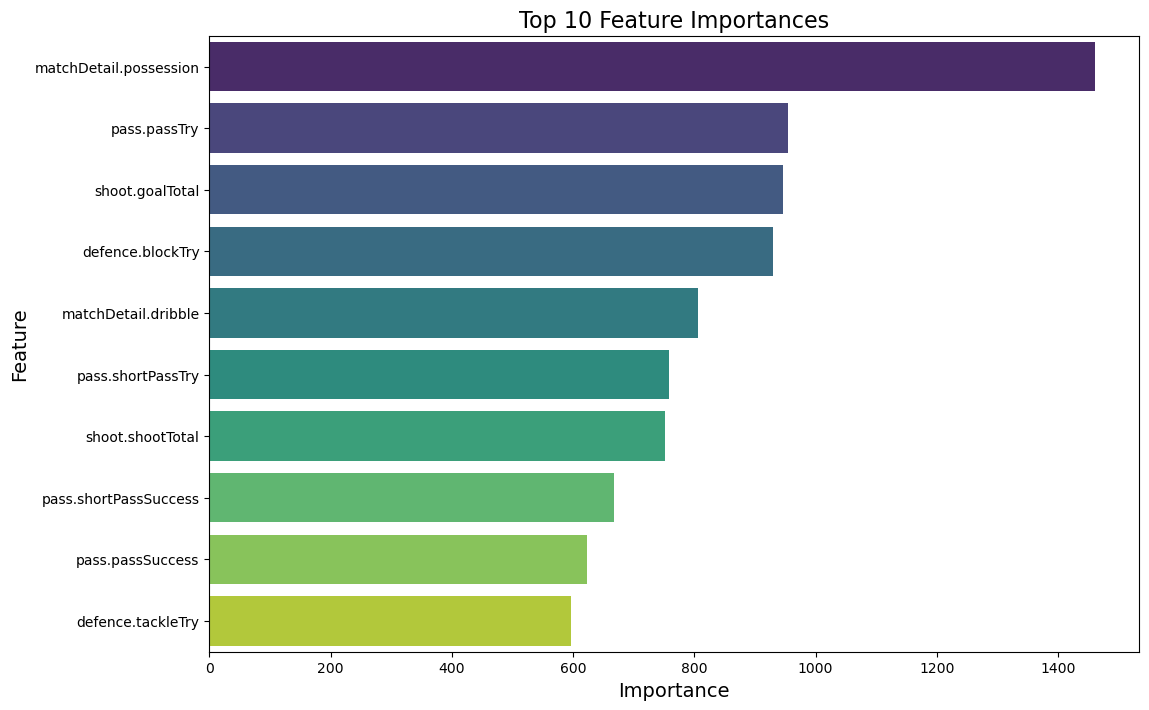

In [ ]:
# 피처 중요도 계산 및 시각화
classifier = pipeline_lgb.named_steps['classifier']
feature_importances = classifier.feature_importances_

encoder = pipeline_lgb.named_steps['preprocessor'].named_transformers_['cat']
encoded_categorical_features = encoder.get_feature_names_out(categorical_features)

# 모든 피처 이름 결합
all_features = np.concatenate([numeric_features, encoded_categorical_features])

# 피처 중요도 상위 10개 출력 및 시각화
feature_importance = pd.Series(feature_importances, index=all_features).sort_values(ascending=False)
top_10_features = feature_importance.head(10)

print("\nTop 10 Features by Importance:\n")
print(top_10_features)

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='viridis')
plt.title('Top 10 Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.show()

In [ ]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[
    ('log_reg', pipeline_lg),
    ('random_forest', pipeline_rf),
    ('xgb', pipeline_xgb),
    ('lgbm', pipeline_lgb)
], voting='soft')  # 소프트 사용

# 모델 학습
ensemble.fit(X_train, y_train)

# 평가
y_pred = ensemble.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

C:\Users\rlatk\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[LightGBM] [Warning] feature_fraction is set=0.640333305238909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.640333305238909
[LightGBM] [Warning] lambda_l1 is set=0.07102890308123432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07102890308123432
[LightGBM] [Warning] lambda_l2 is set=5.277565140017917, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.277565140017917
[LightGBM] [Warning] bagging_fraction is set=0.9629480341500267, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9629480341500267
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.640333305238909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.640333305238909
[LightGBM] [Warning] lambda_l1 is set=0.07102890308123432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07102890308123432
[LightGBM] [Warning] lambda_l2 is set=5